## Description project

We work here for a company specialised in E-commerce who exclusively sells handmade clothes. Management would like us to developp a tool that identifies fraudulent activities in a timely manner to prevent any theft.


#### Scope of work

- Determine user's country from his IP address
- Build a Machine Learning prediction model allowing to categorise a transaction as fraudulent or safe.
- Elaborate on how the model works for a non technical audience who wants to be comfortable using the model


To complete the work, we were provided with two datasets :
- Fraud_data, containing a sample of users with information such as sex, age, signup_time, ip_address ... and wether they commited fraud or not
- One table indicating country from a combination of the lower bound and upper bound of an IP address.

----- 


In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


c:\Users\PC\Data\ads_fraud_detection


In [2]:
from config.config import *
from libs.common import *
#init_notebook_mode(connected=True)
print(tf.__version__) # requires version >= 1.9.0

c:/Users/PC/Data/ads_fraud_detection


c:\Users\PC\Data\ads_fraud_detection\.conda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\PC\Data\ads_fraud_detection\.conda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\PC\Data\ads_fraud_detection\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


2.12.0


In [3]:
save_dir=f"{exps_dir}/exp4"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



In [4]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

# Options

pd.set_option('display.max_columns', 500)


# Function for when we want to drop a column but still keep it in memory in an other dataframe

def to_recycle_bin(column) :
    recycle_ds[column] = dataset[column]
    dataset.drop(column, axis=1, inplace = True)
    
# Function to get a column back from recycle_ds

def restore_from_bin(column) :
    dataset[column] = dataset[column]
    recycle_ds.drop(column, axis=1, inplace = True)

# First we import the data

dataset = pd.read_csv(f"{data_dir}/fraud_ecommerce/Fraud_Data.csv")              # Users information
IP_table = pd.read_csv(f"{data_dir}/fraud_ecommerce/IpAddress_to_Country.csv")   # Country from IP information
recycle_ds = pd.DataFrame()

### Getting information from IP_table

In [5]:
# We want to get country related to each IP address

IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
    
# To affect a country to each IP :
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

# Since this code is time consuming to run, we have saved the result in a file with the following line of code :
dataset.to_csv(f"{save_dir}/Fraud_data_with_country.csv", index=False)

#which allows us to simply import the data if we need to restart the kernel
# dataset = pd.read_csv("../input/datasets-fraud/Fraud_data_with_country.csv")

In [6]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Understanding the data

In [7]:
# We look at what our dataset looks like
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [8]:
# We look at the unique values for the relevant
import pprint
for colonne in ["purchase_value","source","browser","sex","age" ] :
    pprint.pprint("{} : {}".format(colonne, dataset[colonne].unique()))

('purchase_value : [ 34  16  15  44  39  42  11  27  30  62  13  58  18  50  '
 '57  55  40  46\n'
 '  24  47  25  52  31  37  54  12  48  56  72  38  33  53  35  60  91  26\n'
 '  75  51  81  69  36  10  14  29  21  61  41  19  28  65   9  79  23  73\n'
 '  45  20  78  22  32  68  43  82  59  70  63  86  80  66  49  17  64 107\n'
 '  87  67  76  90  88  92  77  85  71  74 101  96  93  98 123  89  84  94\n'
 '  83  99 118 103 112 105  97 120 100 109  95 106 110 102 115 119 111 108\n'
 ' 129 154 116 104 113 117 121 128 127 122 114 132 140 125]')
"source : ['SEO' 'Ads' 'Direct']"
"browser : ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']"
"sex : ['M' 'F']"
('age : [39 53 41 45 18 19 34 43 31 35 32 33 38 24 23 28 36 27 56 21 22 30 57 '
 '44\n'
 ' 40 55 37 20 48 25 46 29 26 47 60 52 42 49 50 58 51 59 62 54 68 64 61 63\n'
 ' 72 67 65 69 66 73 70 71 74 76]')


In [9]:
# Are there multiple lines with the same user_id ?
print("The user_id column includes {} duplicates".format(dataset.duplicated(subset = "user_id", keep =False).sum()))

The user_id column includes 0 duplicates


Conclusion : each row in the table has a unique user_id

In [10]:
# Let's see if the same device_id is sometimes used several times

dup_table = pd.DataFrame(dataset.duplicated(subset = "device_id"))
dup_rate = dup_table.mean()
print("{}% of the dataset is comprised of transactions from a device_id that had been previously used".format(int(dup_rate*1000)/10))

8.7% of the dataset is comprised of transactions from a device_id that had been previously used


In [11]:
# Since we know the same machine_id can be used for several transaction we will 
# look at how many times on average devices with duplicates are used and their distribution

# dataset = pd.read_csv("../input/datasets-fraud/Fraud_data_with_country.csv")

device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)                                  # and then we turn device_id from index to column

dupli = device_duplicates[device_duplicates.freq_device >1]
print("On average, when a device is used more than once it is used {mean} times, and the most used machine was used {maxi} times")
      # .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freq_device.max()*10)/10))

dupli = device_duplicates[device_duplicates.freq_device >2]
print("On average, when a device is used more than twice it is used {mean} times")
      # .format(mean = int(dupli.mean()*10)/10, maxi = int(dupli.freq_device.max()*10)/10))

# finally we merge with dataset
dataset = dataset.merge(device_duplicates, on= "device_id")


On average, when a device is used more than once it is used {mean} times, and the most used machine was used {maxi} times
On average, when a device is used more than twice it is used {mean} times


In [12]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country,freq_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12


### Data exploration

In [13]:
# What is the proportion of fraud in the dataset
print("proportion of fraud in the dataset :" , int(dataset["class"].mean()*1000)/10,"%")

proportion of fraud in the dataset : 9.3 %


[[<matplotlib.axis.XTick at 0x20f807d9d90>,

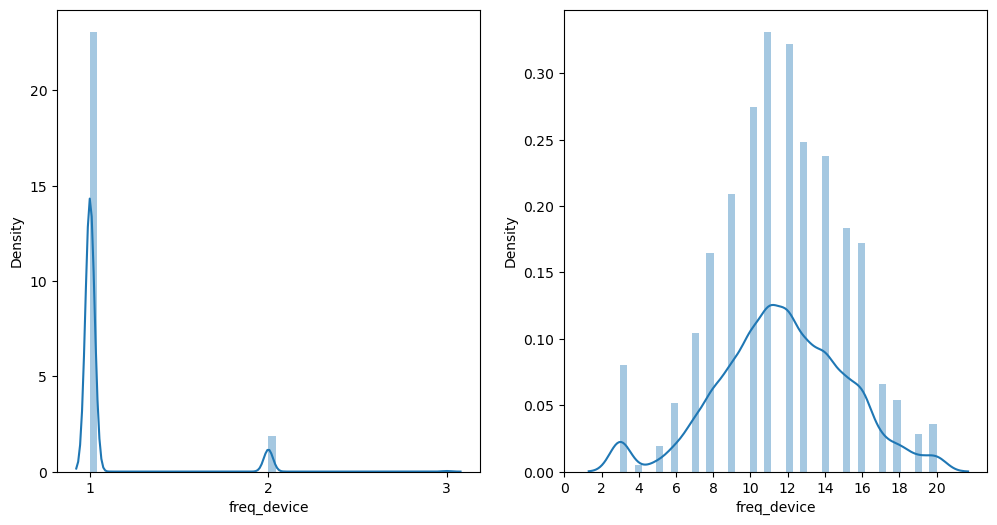

In [14]:
# Let's look at the device frequency distribution to confirm our intuition

f, ax = plt.subplots(1,2,figsize=(12,6))
g1 =sns.distplot(dataset.freq_device[dataset.freq_device <4], ax=ax[0])
g1.set(xticks=[1,2,3])

g2 =sns.distplot(dataset.freq_device[dataset.freq_device >2], ax=ax[1])
g2.set(xticks = range(0,21,2))

In [15]:
dataset['class']

0         0
1         0
2         1
3         1
4         1
         ..
151107    0
151108    0
151109    0
151110    0
151111    0
Name: class, Length: 151112, dtype: int64

In [16]:
# # We look at the likelihood of fraud per category

# f, ax = plt.subplots(1,3, figsize =(18,6))
# f2,ax2 = plt.subplots(3,1, figsize =(24,18))
# dataset["source"] = pd.to_datetime(dataset["source"], errors="coerce")

# sns.barplot(dataset.groupby(by = "source").mean()["class"].index, dataset.groupby(by = "source").mean()["class"], ax=ax[0])
# sns.barplot(dataset.groupby(by = "browser").mean()["class"].index, dataset.groupby(by = "browser").mean()["class"], ax =ax[1])
# sns.barplot(dataset.groupby(by = "sex").mean()["class"].index, dataset.groupby(by = "sex").mean()["class"], ax = ax[2])

# sns.pointplot(x = "purchase_value", y= "class", data = dataset, logistic=True, ci=None, ax =ax2[0])
# sns.pointplot(x = "age", y= "class", data = dataset, logistic=True, ci=None, ax = ax2[1])
# sns.pointplot(x = "freq_device", y= "class", data = dataset, logistic=True, ci=None, ax=ax2[2])

<Axes: xlabel='IP_country'>

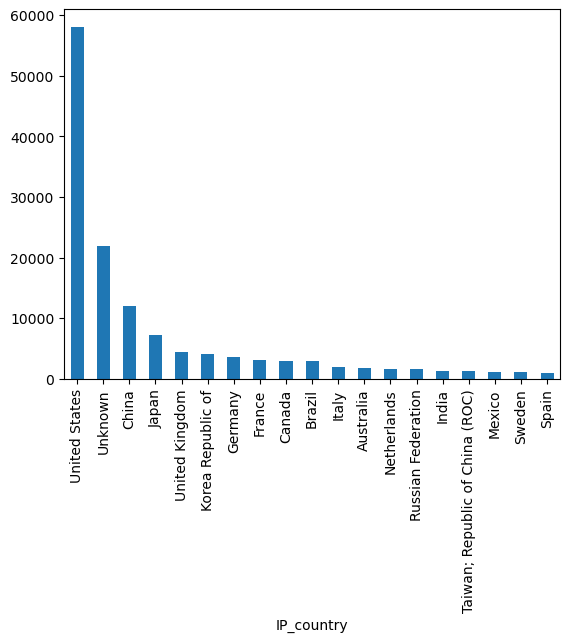

In [17]:
# Overview of distribution by country of origin

dataset.IP_country.value_counts()[dataset.IP_country.value_counts() >1000].plot(kind="bar")

# We note that we have a non negligible amount of Unknown. We keep this as an information as IP that cannot be traced back to a 
# country may be an indication of a fraudulent activity

In [18]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country,freq_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12


In [19]:
# dataset.to_excel(f'{save_dir}/dataset_EDA.xlsx', index=None)
object_columns = list(dataset.select_dtypes(['object']).columns)
dataset[object_columns]=dataset[object_columns].astype('category')
category_columns = list(dataset.select_dtypes(['category']).columns)
numeric_columns = list(dataset.select_dtypes(['number']).columns)

np.savez(f'{save_dir}/columns_dtype.npz', category_columns = category_columns, numeric_columns = numeric_columns)
dataset.to_csv(f'{save_dir}/data_EDA.csv',index=None)